In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from wordcloud import WordCloud
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import tensorflow as tf
from transformers import BertTokenizer
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tokenize as tkn_module
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')

Data load:

In [ ]:
train_data = pd.read_csv("/content/sample_data/train.csv")
test_data = pd.read_csv("/content/sample_data/test.csv")

train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Visualizing data

In [ ]:
print("Shape of the training dataset: {}.".format(train_data.shape))
print("Shape of the testing dataset: {}".format(test_data.shape))
for col in train_data.columns:
    nan_vals = train_data[col].isna().sum()
    pcent = (train_data[col].isna().sum() / train_data[col].count()) * 100
    print("Total NaN values in column '{}' are: {}, which is {:.2f}% of the data in that column".format(col, nan_vals, pcent))

Shape of the training dataset: (7613, 5).
Shape of the testing dataset: (3263, 4)
Total NaN values in column 'id' are: 0, which is 0.00% of the data in that column
Total NaN values in column 'keyword' are: 61, which is 0.81% of the data in that column
Total NaN values in column 'location' are: 2533, which is 49.86% of the data in that column
Total NaN values in column 'text' are: 0, which is 0.00% of the data in that column
Total NaN values in column 'target' are: 0, which is 0.00% of the data in that column


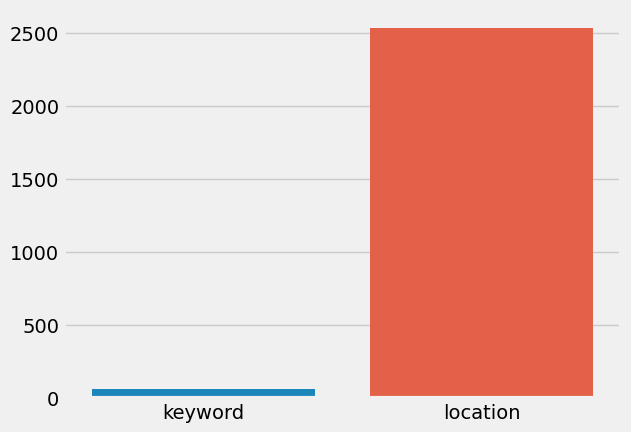

In [ ]:
# Let's plot NaN value distribution
fig = sns.barplot(
    x=train_data[['keyword', 'location']].isna().sum().index,
    y=train_data[['keyword', 'location']].isna().sum().values,
)

visual of target values

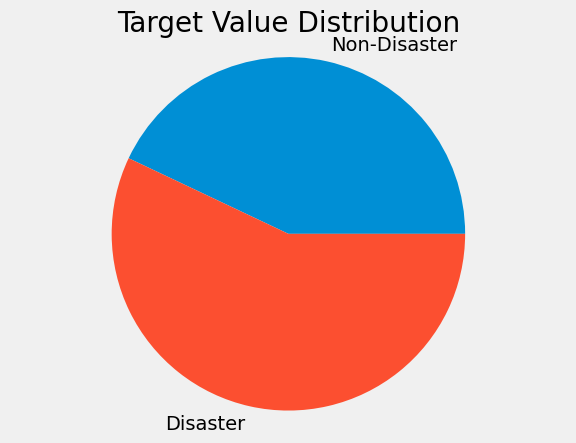

In [ ]:
vals = [len(train_data[train_data['target']==1]['target']), len(train_data[train_data['target']==0]['target'])]

plt.pie(vals, labels=["Non-Disaster", "Disaster"])
plt.axis('equal')
plt.title("Target Value Distribution")
plt.show()

keyword frequency count

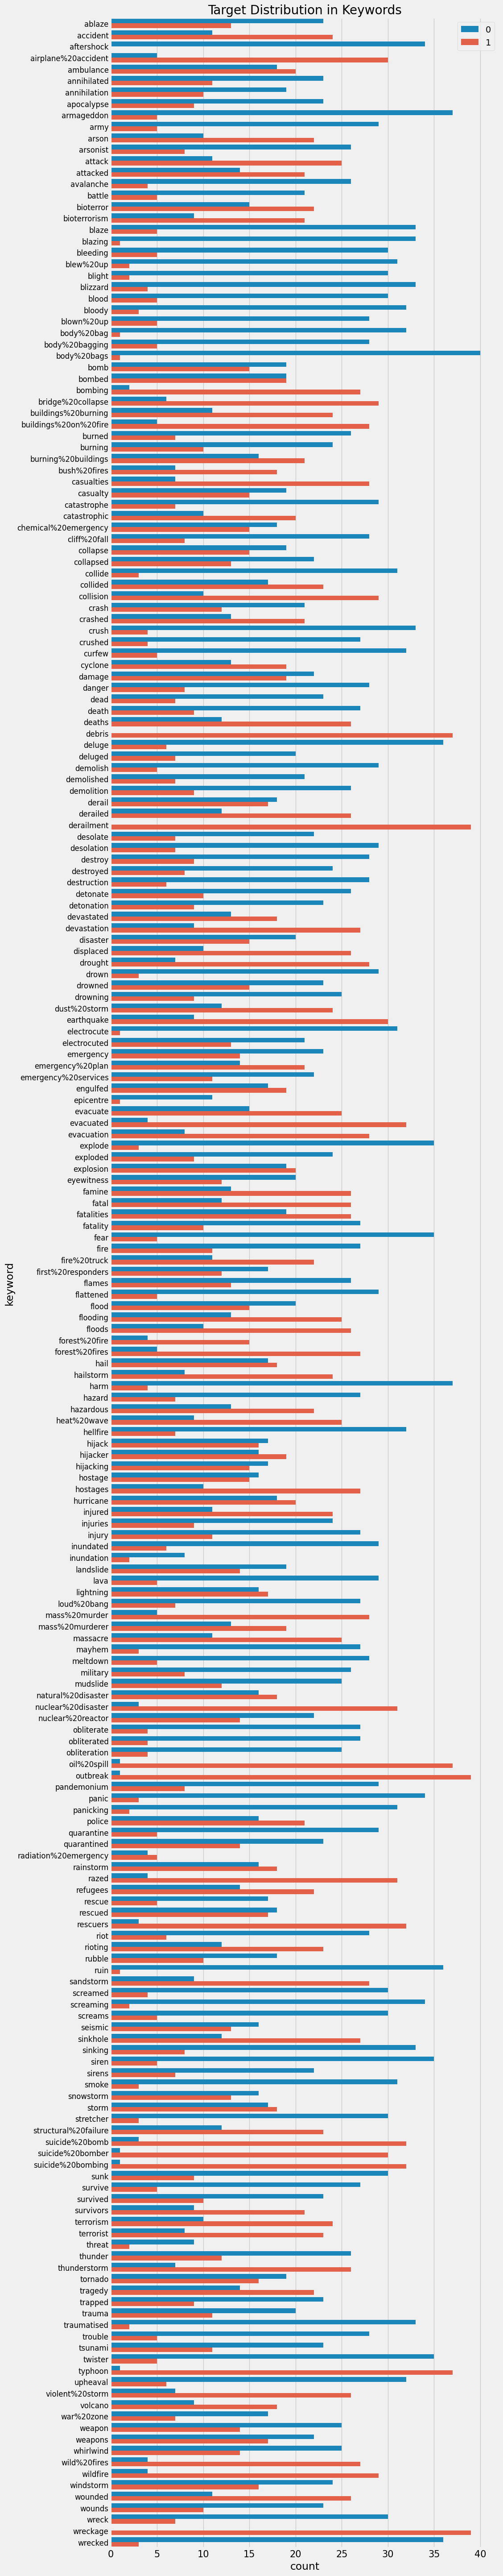

In [ ]:
fig = plt.figure(figsize=(10, 70), dpi=100)
sns.countplot(y=train_data['keyword'].sort_values(), hue=train_data['target'])
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')
fig.show()

charachter count

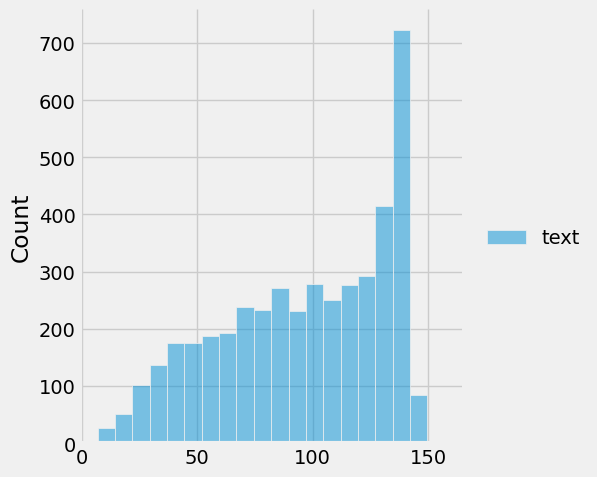

In [ ]:
dis_twt = train_data[train_data['target']==1]['text'].str.len()
non_dis_twt = train_data[train_data['target']==0]['text'].str.len()

sns.displot([dis_twt, non_dis_twt])

word count distribution

In [ ]:
dis_cnt = train_data[train_data['target'] == 1]['text'].str.split().map(lambda x: len(x))
ndis_cnt = train_data[train_data['target'] == 0]['text'].str.split().map(lambda x: len(x))

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x=list(dis_cnt), name='Disaster Tweets'),
    row=1,
    col=1
)

fig.add_trace(
    go.Histogram(x=list(ndis_cnt), name='Non Disaster Tweets'),
    row=1,
    col=2,
)

fig.update_layout(height=500, width=950, title_text="Words Count")
fig.show()

average word length

In [ ]:
dis_avg = train_data[train_data['target']==1]['text'].str.split().map(lambda x: [len(j) for j in x]).map(lambda x: np.mean(x)).to_list()
ndis_avg = train_data[train_data['target']==0]['text'].str.split().map(lambda x: [len(j) for j in x]).map(lambda x: np.mean(x)).to_list()

fig = ff.create_distplot([dis_avg, ndis_avg], ['Disaster', 'Non Disaster'])
fig.update_layout(height=500, width=950, title_text="Average Word Length Distribution")
fig.show()

unique word count distribution

In [ ]:
dis_uvc = train_data[train_data['target']==1]['text'].apply(lambda x: len(set(str(x).split()))).to_list()
ndis_uvc = train_data[train_data['target']==0]['text'].apply(lambda x: len(set(str(x).split()))).to_list()

fig = ff.create_distplot([dis_uvc, ndis_uvc], ['Disaster', 'Non Disaster'])
fig.update_layout(height=500, width=950, title_text="Unique Word Count Distribution")
fig.show()

URL count

In [ ]:
dis_uc = train_data[train_data['target']==1]['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w])).to_list()
ndis_uc = train_data[train_data['target']==0]['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w])).to_list()

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x=dis_uc, name='Disaster Tweets'),
    row=1,
    col=1
)

fig.add_trace(
    go.Histogram(x=ndis_uc, name='Non Disaster Tweets'),
    row=1,
    col=2,
)

fig.update_layout(height=500, width=950, title_text="URL Count")
fig.show()

word cloud for diaster and non disaster tweets

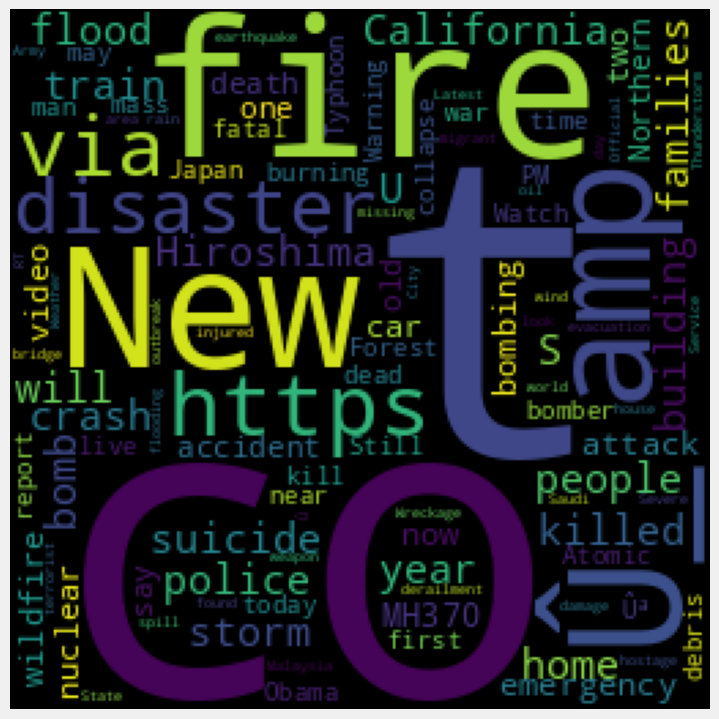

In [ ]:
dis_snt = train_data[train_data['target']==1]['text'].to_list()
dis_snt = " ".join(dis_snt)

dis_wc = WordCloud(width=256, height=256, collocations=False).generate(dis_snt)
plt.figure(figsize = (7,7))
plt.imshow(dis_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

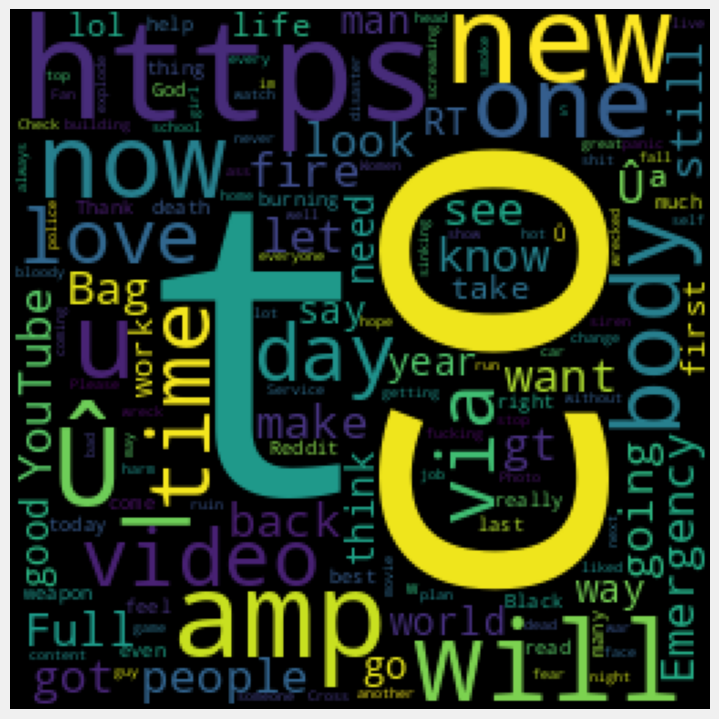

In [ ]:
ndis_snt = train_data[train_data['target']==0]['text'].to_list()
ndis_snt = " ".join(ndis_snt)

ndis_wc = WordCloud(width=256, height=256, collocations=False).generate(ndis_snt)
plt.figure(figsize = (7,7))
plt.imshow(ndis_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

MODELS:
Fine tuned BERT model

In [ ]:
# Load the BERT model from TensorFlow Hub
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1", trainable=True)

# Load the BERT tokenizer from Hugging Face Transformers
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens, all_masks, all_segments = [], [], []

    for text in tqdm(texts):
        # Tokenize the current text
        text = tokenizer.tokenize(text)
        # Select text only till
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

getting model from TFHub

Get the model from TFHub and the vocab file with it



In [ ]:
%%time
url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(url, trainable=True)

CPU times: user 13 s, sys: 3.65 s, total: 16.7 s
Wall time: 16.4 s


In [ ]:
# Print the type of the tokenizer before calling bert_encode
print(type(tokenizer))

<class 'transformers.models.bert.tokenization_bert.BertTokenizer'>


encoding the data

In [ ]:
%%time
train_input = bert_encode(train_data['text'].values, tokenizer, max_len=200)
test_input = bert_encode(test_data['text'].values, tokenizer, max_len=200)
train_labels = train_data['target'].values

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

CPU times: user 9.52 s, sys: 65.8 ms, total: 9.59 s
Wall time: 10.4 s


building the model

In [ ]:
def build_model(transformer, max_len=512):
    # Naming your keras ops is very important 😉
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_word_ids')
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name='input_mask')
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name='segment_ids')
    # Get the sequence output
    _, seq_op = transformer([input_word_ids, input_mask, segment_ids])
    # Get the respective class token from that sequence output
    class_tkn = seq_op[:, 0, :]
    # Final Neuron (for Classification)
    op = Dense(1, activation='sigmoid')(class_tkn)
    # Bind the inputs and outputs together into a Model
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=op)

    model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

    return model

training the model:

In [ ]:
# Build the model
model = build_model(bert_layer, max_len=200)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 200)]                0         []                            
                                                                                                  
 segment_ids (InputLayer)    [(None, 200)]                0         []                            
                                                                                                  
 keras_layer_1 (KerasLayer)  [(None, 1024),               3351418   ['input_word_ids[0][0]',  

In [ ]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.1,
    epochs=3,
    callbacks=[checkpoint],
    batch_size=8
)